#Data Science Capstone
***

```
this notebook is used for data science capstone project. highly recommeded to run on jupyter environment
```

    author: kevin elfri
github: [kevin's repo](https://github.com/zylbergs/zylpy)

# Problem Understanding

1. we want to open new coffee shop branch in somewhere in yogyakarta
2. provide location options to estabilish the new branch
3. location option should in village level
4. cannot afford third party data vendor
5. preferably presented in geological map
6. success criteria : location with lowest competitors and higest potential customers
7. the data required might be scattered somewhere in open public
8. our target customers are college university students and office workers
9. we know that working place and college university mainly available in two main regency : Sleman and Kota Yogykarta


# Analytics Approach
1. Geospatial analysis and visualization
2. Clustering 

# Data Requirements
1. sub district data
2. places/venues
3. geo coordinate


# Data Collection

1. web scraping
2. foursquare api request
3. nominatim openstreetmap

# Data Understanding
1. EDA
2. Geospatial visualzation
3. cluster label

# Data Preparation
1. Data ingesition
2. data reformating
3. feature selection
4. missing value handling
5. correct wrong information

# Modeling
1. Spatial Visualization
2. Clustering : KMeans

# Evaluation
1. Inertia
2. cluster label understading

# Deployment
1. map html
2. model object: joblib/pickle format

# Working Section

### import required library

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
import requests
import json
from bs4 import BeautifulSoup

!pip install geopy
!pip install folium
!pip install selenium

from geopy.geocoders import Nominatim
import folium 
import selenium
from selenium import webdriver
import sys
import joblib
import pickle
#colabs requirements
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 911kB 11.6MB/s 
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Relea

In [ ]:
pd.set_option('display.max_rows',None)

# Web scraping Section

### Data Version 1

In [ ]:
#credentials
client_id = '3DDRIZ0SKFRREIRMDBN30EFPHWBZ1ROU3CHHK4E3PMSXA0W3'
client_secret = 'ZLSBPJSRJKAMGSSK1IYBD1HMP02DKDYCZHAJDK0PZDDKHU3J'
client_id2 = 'ILH0RNQVV3NDMRFLFSZMNFXDM02DDQEQ5AIKRMMKO0BVRPER'
client_secret2 = '4AGDUDTRM4VUHYM3FEJGSWT4P3ZWTMEGG5OUVSIMTTVEW2ZF'
version = '20200701'


In [34]:
url2 = ['https://id.wikipedia.org/wiki/Daftar_kapanewon,_kemantren,_kalurahan,_dan_kelurahan_di_Daerah_Istimewa_Yogyakarta']

In [ ]:
source = requests.get(url2[0]).text
soup = BeautifulSoup(source,'lxml')

#limit the result to only two regency: SLEMAN, KOTA YOGYAKARTA
#idx 0 : Sleman, idx 1: kota yogyakarta
tables = soup.find_all('table')[4:6]

In [ ]:
def return_subdist_village(data,index=None):
    sub_district = []
    village = []
    clean_village = []
    #per row scope
    rows = data.find_all('tr')
    for i in rows[1:]:
        if i.find('a') == None:
            continue
        else:
            sub_district.append(i.find('a').text) # a tag: subdistrict data
        #ul, li tag: village data
        villages = i.find('ul')
        villages2 = i.find_all('li')
        village.append(villages.text.split('\n'))
        for j in villages2:
            clean_village.append(j.text)

    newsub = list()
    #attemp to match subdistrict and village length
    for i,j in zip(sub_district,village):
        new = [i for a in range(len(j))]
        newsub.append(new)
    #flatten the result
    newsub = [y for x in newsub for y in x]
    #converting into pandas dataframe
    if index == 0:
        df = pd.DataFrame({'Regency':['Sleman' for i in range(len(newsub))],
                           'Sub_District':newsub,
                           'Village':clean_village})
    else:
        df = pd.DataFrame({'Regency':['Kota Yogyakarta' for i in range(len(newsub))],
                           'Sub_District':newsub,
                           'Village':clean_village})
        
    return df

In [ ]:
def generate_coordinate(data):
    lat = []
    lon=[]
    for i in data['Village']:
        query = f'{i}, Yogyakarta'
        geolocator = Nominatim(user_agent='kevinelfri@ymail.com')
        coords = geolocator.geocode(query)
        try:
            lat.append(coords.latitude)
            lon.append(coords.longitude)
        except:
            lat.append(np.nan)
            lon.append(np.nan)
    data = data
    data['Latitude'] = lat
    data['Longitude'] = lon
    return data


In [ ]:
sleman = return_subdist_village(tables[0],index=0)
kota_yk = return_subdist_village(tables[1],index=1)
full_regency = pd.concat([sleman,kota_yk],axis=0).reset_index(drop=True)
#correcting wrong name
full_regency.loc[full_regency['Village']=='Wukisari','Village'] = 'Wukirsari'
full_regency.loc[full_regency['Village']=='Mujamuju','Village'] = 'Muja muju'
#generate coordinate
full_regency = generate_coordinate(full_regency)
#-7.7492391,110.2856145 : recalibration coords 
full_regency.loc[full_regency['Village']=='Sidorejo','Latitude'] = -7.7492391
full_regency.loc[full_regency['Village']=='Sidorejo','Longitude'] = 110.2856145
full_regency.loc[full_regency['Village']=='Triharjo','Latitude'] = -7.6945594
full_regency.loc[full_regency['Village']=='Triharjo','Longitude'] = 110.3502065

In [ ]:
#check null values
full_regency.loc[full_regency['Longitude'].isnull()]

,Regency,Sub_District,Village,Latitude,Longitude


# Spatial Visualization

In [ ]:
def yog_map(data,use_border=True,geojson_path=None):
    yog_query = 'Yogyakarta, ID'
    geolocator= Nominatim(user_agent='kevinelfri@ymail.com')
    yog_coords = geolocator.geocode(yog_query)

    yog_map = folium.Map(location=[yog_coords.latitude,yog_coords.longitude],zoom_start=11)
    if use_border ==True:
        folium.GeoJson(geojson_path, name="geojson").add_to(yog_map)
    for i,j,s,r in zip(data['Latitude'],data['Longitude'],data['Village'],data['Sub_District']):
        label ='{}, {}, Yogyakarta'.format(s,r)
        label = folium.Popup(label,parse_html=True)
        folium.CircleMarker(location=[i,j],popup=label,color='red',fill=True,fill_color='red',fill_opacity=0.4).add_to(yog_map)
    return yog_map

In [ ]:
yogyakarta_map = yog_map(full_regency,geojson_path='/content/YK_geojson.geojson')
yogyakarta_map

# Request Required Venues using Fourquare

In [ ]:
college = []
for i,j in zip(full_regency['Latitude'],full_regency['Longitude']):
    # college category 4d4b7105d754a06372d81259
    college_request = f'https://api.foursquare.com/v2/venues/explore?client_id={client_id2}&client_secret={client_secret2}&v={version}&ll={i},{j}&limit=100&radius=700&q=College%20%26%20University&categoryId=4d4b7105d754a06372d81259'
    college_results = requests.get(college_request).json()
    try:
        college.append(len(college_results['response']['groups'][0]['items']))
    except:
        college.append(0)


In [ ]:
office = []
for i,j in zip(full_regency['Latitude'],full_regency['Longitude']):
    #coffee category 4bf58dd8d48988d1e0931735
    office_request = f'https://api.foursquare.com/v2/venues/explore?client_id={client_id2}&client_secret={client_secret2}&v={version}&ll={i},{j}&limit=100&radius=700&categoryId=4bf58dd8d48988d124941735'
    office_results = requests.get(office_request).json()
    try:
        office.append(len(office_results['response']['groups'][0]['items']))
    except:
        office.append(0)

In [ ]:
coffee = []
for i,j in zip(full_regency['Latitude'],full_regency['Longitude']):
    # office category 4bf58dd8d48988d124941735
    coffee_request = f'https://api.foursquare.com/v2/venues/explore?client_id={client_id2}&client_secret={client_secret2}&v={version}&ll={i},{j}&limit=100&radius=700&categoryId=4bf58dd8d48988d1e0931735'
    coffee_results = requests.get(coffee_request).json()
    try:
        coffee.append(len(coffee_results['response']['groups'][0]['items']))
    except:
        coffee.append(0)

# Combine All information to DataFrame

In [ ]:
full_regency['Number_College_Venues'] = college
full_regency['Number_Office_Venues'] = office
full_regency['Number_Coffee_Venues'] = coffee

In [ ]:
#full_regency.to_csv('Final_Data_SLE_YK.csv',index=False,index_label=False)

# Clustering Section

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X = full_regency[['Number_College_Venues','Number_Office_Venues','Number_Coffee_Venues']]

In [ ]:
def best_k_kmeans(X,n_clu):
    inertia = []
    for i in range(n_clu):
        kmeans = KMeans(n_clusters=i+1,random_state=1,algorithm='elkan')
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(1,n_clu+1),inertia)
    plt.xlabel('N Cluster')
    plt.ylabel('Inertia')
    plt.show
    return inertia


[41283.48091603054,
 17180.796726190478,
 9430.934865900384,
 7349.295977011496,
 6033.778365045807,
 4885.949741315595,
 4006.184756532719,
 3451.7106767549394,
 2962.193342391304,
 2668.693342391304]

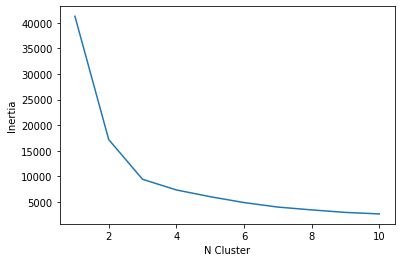

In [ ]:
cluster_result = best_k_kmeans(X,10)
cluster_result

In [ ]:
best_k = 3
kmeans = KMeans(n_clusters=3,algorithm='elkan')
kmeans.fit(X)
clu_label = kmeans.labels_
full_regency['Cluster_Label'] = clu_label

In [ ]:
filename = 'Coffee_NewBranch_Kmeans_cluster.pkl'
with open(filename,'wb') as f:
    pickle.dump(kmeans,f)
    f.close()

In [ ]:
full_regency.head()

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label
0,Sleman,Berbah,Jogotirto,-7.812950,110.472060,2,0,1,0
1,Sleman,Berbah,Kalitirto,-7.795132,110.455358,4,0,0,0
2,Sleman,Berbah,Sendangtirto,-7.820442,110.431366,8,0,2,0
3,Sleman,Berbah,Tegaltirto,-7.805423,110.441725,13,0,0,0
4,Sleman,Cangkringan,Argomulyo,-7.670610,110.457459,0,0,0,0


# Visualizing the Cluster

In [ ]:
def yog_cluster_map(kclusters= 3):
    yog_query = 'Yogyakarta, ID'
    geolocator= Nominatim(user_agent='kevinelfri@ymail.com')
    yog_coords = geolocator.geocode(yog_query)
    yog_map = folium.Map(location=[yog_coords.latitude,yog_coords.longitude],zoom_start=11)
    

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, poi, cluster in zip(full_regency['Latitude'], full_regency['Longitude'], full_regency['Village'], full_regency['Cluster_Label']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(yog_map)
       
    return yog_map

In [ ]:
yog_cluster_map()

In [ ]:
yogyakarta_map.save('Sleman_Yogyakarta_village.html')
yog_cluster_map().save('Village Cluster Map.html')

# Cluster Result Analysis

In [3]:
full_regency = pd.read_csv('/content/Final_Data_SLE_YK.csv')
full_regency.head()

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label
0,Sleman,Berbah,Jogotirto,-7.812950,110.472060,2,0,1,0
1,Sleman,Berbah,Kalitirto,-7.795132,110.455358,4,0,0,0
2,Sleman,Berbah,Sendangtirto,-7.820442,110.431366,8,0,2,0
3,Sleman,Berbah,Tegaltirto,-7.805423,110.441725,13,0,0,0
4,Sleman,Cangkringan,Argomulyo,-7.670610,110.457459,0,0,0,0


In [4]:
clu_1 = full_regency.loc[full_regency['Cluster_Label'] == 0]
clu_2 = full_regency.loc[full_regency['Cluster_Label'] == 1]
clu_3 = full_regency.loc[full_regency['Cluster_Label'] == 2]

### Cluster 1 characteristics

In [6]:
clu_1.to_csv('cluster1 villages.csv',index=False,index_label=False)
clu_1.head()

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label
0,Sleman,Berbah,Jogotirto,-7.812950,110.472060,2,0,1,0
1,Sleman,Berbah,Kalitirto,-7.795132,110.455358,4,0,0,0
2,Sleman,Berbah,Sendangtirto,-7.820442,110.431366,8,0,2,0
3,Sleman,Berbah,Tegaltirto,-7.805423,110.441725,13,0,0,0
4,Sleman,Cangkringan,Argomulyo,-7.670610,110.457459,0,0,0,0


In [7]:
clu_1.agg({'Number_College_Venues':['sum'],'Number_Office_Venues':['sum'],'Number_Coffee_Venues':['sum']})

,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues
sum,246,54,178


In [8]:
clu_1_venues = clu_1.groupby(['Sub_District']).sum()[['Number_College_Venues','Number_Office_Venues','Number_Coffee_Venues']].reset_index()
clu_1_venues['Customer_to_Competitor_r'] = (clu_1_venues['Number_College_Venues']+clu_1_venues['Number_Office_Venues'])/clu_1_venues['Number_Coffee_Venues']
clu_1_venues = clu_1_venues.sort_values('Customer_to_Competitor_r',ascending=False)
clu_1_venues.to_csv('Cluster 1 characteristic.csv',index=False,index_label=False)
clu_1_venues

,Sub_District,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Customer_to_Competitor_r
0,Berbah,27,0,3,9.000000
3,Gamping,40,3,17,2.529412
5,Kalasan,12,2,6,2.333333
18,Umbulharjo,11,3,6,2.333333
19,Wirobrajan,8,5,6,2.166667
15,Sleman,12,10,11,2.000000
2,Depok,7,1,4,2.000000
6,Kotagede,10,11,11,1.909091
13,Prambanan,14,0,8,1.750000
11,Ngemplak,13,2,9,1.666667


### Cluster 2 Characteristics

In [7]:
clu_2.to_csv('cluster2 villages.csv',index=False,index_label=False)
clu_2.head()

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label
8,Sleman,Cangkringan,Umbulharjo,-7.814378,110.387374,20,9,12,1
9,Sleman,Depok,Caturtunggal,-7.767398,110.388492,28,16,30,1
10,Sleman,Depok,Condongcatur,-7.754129,110.400619,4,13,13,1
34,Sleman,Mlati,Sinduadi,-7.758232,110.372737,32,5,13,1
86,Kota Yogyakarta,Danurejan,Bausasran,-7.799362,110.373181,15,27,9,1


In [10]:
clu_2.agg({'Number_College_Venues':['sum'],'Number_Office_Venues':['sum'],'Number_Coffee_Venues':['sum']})

,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues
sum,708,487,408


In [11]:
clu_2_venues = clu_2.groupby('Sub_District').sum()[['Number_College_Venues','Number_Office_Venues','Number_Coffee_Venues']].reset_index()
clu_2_venues['Customer_to_Competitor_r'] = (clu_2_venues['Number_College_Venues']+clu_2_venues['Number_Office_Venues'])/clu_2_venues['Number_Coffee_Venues']
clu_2_venues = clu_2_venues.sort_values('Customer_to_Competitor_r',ascending=False)
clu_2_venues.to_csv('Cluster 2 characteristic.csv',index=False,index_label=False)
clu_2_venues

,Sub_District,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Customer_to_Competitor_r
4,Gondokusuman,27,18,4,11.250000
16,Wirobrajan,42,13,6,9.166667
12,Ngampilan,57,19,11,6.909091
14,Tegalrejo,83,39,22,5.545455
15,Umbulharjo,107,81,39,4.820513
13,Pakualaman,33,48,25,3.240000
1,Danurejan,28,53,26,3.115385
10,Mergangsan,89,33,40,3.050000
6,Jetis,18,27,15,3.000000
11,Mlati,32,5,13,2.846154


### Cluster 3 characteristics

In [8]:
clu_3.to_csv('cluster3 villages.csv',index=False,index_label=False)
clu_3.head()

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label
88,Kota Yogyakarta,Danurejan,Suryatmajan,-7.792839,110.367340,13,34,44,2
90,Kota Yogyakarta,Gedongtengen,Sosromenduran,-7.789338,110.363376,12,33,46,2
92,Kota Yogyakarta,Gondokusuman,Demangan,-7.784871,110.390029,34,31,35,2
93,Kota Yogyakarta,Gondokusuman,Klitren,-7.783821,110.383390,28,28,29,2
94,Kota Yogyakarta,Gondokusuman,Kotabaru,-7.786830,110.373433,33,42,31,2


In [13]:
clu_3.agg({'Number_College_Venues':['sum'],'Number_Office_Venues':['sum'],'Number_Coffee_Venues':['sum']})

,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues
sum,177,286,319


In [14]:
clu_3_venues = clu_3.groupby('Sub_District').sum()[['Number_College_Venues','Number_Office_Venues','Number_Coffee_Venues']].reset_index()
clu_3_venues['Customer_to_Competitor_r'] = (clu_3_venues['Number_College_Venues']+clu_3_venues['Number_Office_Venues'])/clu_3_venues['Number_Coffee_Venues']
clu_3_venues = clu_3_venues.sort_values('Customer_to_Competitor_r',ascending=False)
clu_3_venues.to_csv('Cluster 3 characteristic.csv',index=False,index_label=False)
clu_3_venues

,Sub_District,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Customer_to_Competitor_r
2,Gondokusuman,113,151,145,1.820690
3,Jetis,39,68,84,1.273810
0,Danurejan,13,34,44,1.068182
1,Gedongtengen,12,33,46,0.978261


### deep dive into top 5 subdistricts customer to competitor ratio


In [15]:
#subdistrict Gondokusuman
top_subdistricts1 = clu_2.loc[clu_2['Sub_District']=='Gondokusuman'].copy()
top_subdistricts1['Customer_to_Competitor_r'] = (top_subdistricts1['Number_College_Venues']+top_subdistricts1['Number_Office_Venues'])/top_subdistricts1['Number_Coffee_Venues']
top_subdistricts1

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r
91,Kota Yogyakarta,Gondokusuman,Baciro,-7.79347,110.382973,27,18,4,1,11.25


In [16]:
#subdistrict Wirobrajan
top_subdistricts2 = clu_2.loc[clu_2['Sub_District']=='Wirobrajan'].copy()
top_subdistricts2['Customer_to_Competitor_r'] = (top_subdistricts2['Number_College_Venues']+top_subdistricts2['Number_Office_Venues'])/top_subdistricts2['Number_Coffee_Venues']
top_subdistricts2

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r
128,Kota Yogyakarta,Wirobrajan,Pakuncen,-7.796965,110.351131,20,9,3,1,9.666667
130,Kota Yogyakarta,Wirobrajan,Wirobrajan,-7.802624,110.350447,22,4,3,1,8.666667


In [17]:
#subdistrict Berbah
top_subdistricts3 = clu_1.loc[clu_1['Sub_District']=='Berbah'].copy()
top_subdistricts3['Customer_to_Competitor_r'] = (top_subdistricts3['Number_College_Venues']+top_subdistricts3['Number_Office_Venues'])/top_subdistricts3['Number_Coffee_Venues']
#smoothed +1
top_subdistricts3.loc[top_subdistricts3['Village'] == 'Kalitirto','Customer_to_Competitor_r'] = 5.0
top_subdistricts3.loc[top_subdistricts3['Village'] == 'Tegaltirto','Customer_to_Competitor_r'] = 14.0
top_subdistricts3

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r
0,Sleman,Berbah,Jogotirto,-7.812950,110.472060,2,0,1,0,2.0
1,Sleman,Berbah,Kalitirto,-7.795132,110.455358,4,0,0,0,5.0
2,Sleman,Berbah,Sendangtirto,-7.820442,110.431366,8,0,2,0,4.0
3,Sleman,Berbah,Tegaltirto,-7.805423,110.441725,13,0,0,0,14.0


In [18]:
#subdistrict Berbah Ngampilan
top_subdistricts4 = clu_2.loc[clu_2['Sub_District']=='Ngampilan'].copy()
top_subdistricts4['Customer_to_Competitor_r'] = (top_subdistricts4['Number_College_Venues']+top_subdistricts4['Number_Office_Venues'])/top_subdistricts4['Number_Coffee_Venues']
top_subdistricts4

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r
113,Kota Yogyakarta,Ngampilan,Ngampilan,-7.802183,110.357615,27,10,5,1,7.4
114,Kota Yogyakarta,Ngampilan,Notoprajan,-7.804768,110.354997,30,9,6,1,6.5


In [19]:
#subdistrict Berbah Tegalrejo
top_subdistricts5 = clu_2.loc[clu_2['Sub_District']=='Tegalrejo'].copy()
top_subdistricts5['Customer_to_Competitor_r'] = (top_subdistricts5['Number_College_Venues']+top_subdistricts5['Number_Office_Venues'])/top_subdistricts5['Number_Coffee_Venues']
top_subdistricts5

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r
117,Kota Yogyakarta,Tegalrejo,Bener,-7.776131,110.352393,18,5,4,1,5.750000
118,Kota Yogyakarta,Tegalrejo,Karangwaru,-7.774269,110.364112,28,12,11,1,3.636364
119,Kota Yogyakarta,Tegalrejo,Kricak,-7.773404,110.356933,13,8,5,1,4.200000
120,Kota Yogyakarta,Tegalrejo,Tegalrejo,-7.780455,110.355073,24,14,2,1,19.000000


In [26]:
#closer look on village level
consider_village = pd.concat([top_subdistricts1,top_subdistricts2,top_subdistricts3,top_subdistricts4,top_subdistricts5])
consider_village = consider_village.sort_values('Customer_to_Competitor_r',ascending=False).reset_index(drop=True)
consider_village

,Regency,Sub_District,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r
0,Kota Yogyakarta,Tegalrejo,Tegalrejo,-7.780455,110.355073,24,14,2,1,19.000000
1,Sleman,Berbah,Tegaltirto,-7.805423,110.441725,13,0,0,0,14.000000
2,Kota Yogyakarta,Gondokusuman,Baciro,-7.793470,110.382973,27,18,4,1,11.250000
3,Kota Yogyakarta,Wirobrajan,Pakuncen,-7.796965,110.351131,20,9,3,1,9.666667
4,Kota Yogyakarta,Wirobrajan,Wirobrajan,-7.802624,110.350447,22,4,3,1,8.666667
5,Kota Yogyakarta,Ngampilan,Ngampilan,-7.802183,110.357615,27,10,5,1,7.400000
6,Kota Yogyakarta,Ngampilan,Notoprajan,-7.804768,110.354997,30,9,6,1,6.500000
7,Kota Yogyakarta,Tegalrejo,Bener,-7.776131,110.352393,18,5,4,1,5.750000
8,Sleman,Berbah,Kalitirto,-7.795132,110.455358,4,0,0,0,5.000000
9,Kota Yogyakarta,Tegalrejo,Kricak,-7.773404,110.356933,13,8,5,1,4.200000


In [28]:
#ingest demographics from another webscraping notebook
top_5_demographics = pd.read_csv('/content/Productive_population_15to64_of_top5_subdistricts.csv')
top_5_demographics.head()

,Sub_District,Village,Total_Population
0,Gondokusuman,Demangan,6.269
1,Gondokusuman,Kotabaru,2.088
2,Gondokusuman,Klitren,6.968
3,Gondokusuman,Baciro,8.927
4,Gondokusuman,Terban,6.647


In [32]:
#join all information
complete_data = pd.merge(consider_village,top_5_demographics,on='Village')
complete_data.drop('Sub_District_y',axis=1,inplace=True)
complete_data.to_csv('Complete_data_strategic_establishment.csv',index=False,index_label=False)

In [33]:
complete_data

,Regency,Sub_District_x,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r,Total_Population
0,Kota Yogyakarta,Tegalrejo,Tegalrejo,-7.780455,110.355073,24,14,2,1,19.000000,6.540
1,Sleman,Berbah,Tegaltirto,-7.805423,110.441725,13,0,0,0,14.000000,8.833
2,Kota Yogyakarta,Gondokusuman,Baciro,-7.793470,110.382973,27,18,4,1,11.250000,8.927
3,Kota Yogyakarta,Wirobrajan,Pakuncen,-7.796965,110.351131,20,9,3,1,9.666667,7.712
4,Kota Yogyakarta,Wirobrajan,Wirobrajan,-7.802624,110.350447,22,4,3,1,8.666667,6.749
5,Kota Yogyakarta,Ngampilan,Ngampilan,-7.802183,110.357615,27,10,5,1,7.400000,7.367
6,Kota Yogyakarta,Ngampilan,Notoprajan,-7.804768,110.354997,30,9,6,1,6.500000,5.798
7,Kota Yogyakarta,Tegalrejo,Bener,-7.776131,110.352393,18,5,4,1,5.750000,3.529
8,Sleman,Berbah,Kalitirto,-7.795132,110.455358,4,0,0,0,5.000000,9.692
9,Kota Yogyakarta,Tegalrejo,Kricak,-7.773404,110.356933,13,8,5,1,4.200000,9.443


In [10]:
complete_data = pd.read_csv('/content/Complete_data_strategic_establishment.csv')
complete_data.head()

,Regency,Sub_District_x,Village,Latitude,Longitude,Number_College_Venues,Number_Office_Venues,Number_Coffee_Venues,Cluster_Label,Customer_to_Competitor_r,Total_Population
0,Kota Yogyakarta,Tegalrejo,Tegalrejo,-7.780455,110.355073,24,14,2,1,19.000000,6.540
1,Sleman,Berbah,Tegaltirto,-7.805423,110.441725,13,0,0,0,14.000000,8.833
2,Kota Yogyakarta,Gondokusuman,Baciro,-7.793470,110.382973,27,18,4,1,11.250000,8.927
3,Kota Yogyakarta,Wirobrajan,Pakuncen,-7.796965,110.351131,20,9,3,1,9.666667,7.712
4,Kota Yogyakarta,Wirobrajan,Wirobrajan,-7.802624,110.350447,22,4,3,1,8.666667,6.749


In [17]:
strategic_place = folium.Map(location=[-7.793470,110.382973],zoom_start=13)
folium.GeoJson('/content/YK_geojson.geojson').add_to(strategic_place)
for i,j,k,l in zip(complete_data['Latitude'],complete_data['Longitude'],complete_data['Village'],complete_data['Sub_District_x']):
    label = folium.Popup('{}, {}'.format(k,l),parse_html=True)
    folium.Marker(location=[i,j],popup=label).add_to(strategic_place)
strategic_place

In [18]:
strategic_place.save('Strategic_place_to_establish.html')

# Conclussion

key takeaway: 
1. ratio of potential customers over competitors in cluster 1 = 17 : 10
2. ratio of potential customers over competitors in cluster 2 = 29 : 10
3. ratio of potential customers over competitors in cluster 3 = 3 : 2
4. based on the potential customers to competitors ratio, here are top 5 
Sub-districts to consider: 
    - Gondokusuman
    - Wirobrajan
    - Berbah
    - Ngampilan
    - Tegalrejo
5. top villages to consider:
    - Tegalrejo
    - Tegaltirto
    - Baciro
    - Pakuncen
    - Wirobrajan
    - Ngampilan
    - Notoprajan
    - Bener
    - Kalitirto
    - Kricak
    - Sendangtirto
    - Jogotirto